# L3 SSH SWOT SWATH data processing

#### Imports

In [2]:
import os
import glob
import sys

import matplotlib.pyplot as plt

import numpy as np
import xarray as xr
import jax
import jax.numpy as jnp
import optax

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
import utils
import L3Field_filtering


path_L3swot  = '/home/bouxdecl/Documents/data/FIELDS/L3_data/karin' 
path_save_data = '../save_data/fields_data'

In [3]:
files = sorted(glob.glob(os.path.join(path_L3swot, 'SWOT_L3_LR_SSH_Expert_*_003_2023*T*_2023*T*_v0.3.nc')))
files[:3]

['/home/bouxdecl/Documents/data/FIELDS/L3_data/karin/SWOT_L3_LR_SSH_Expert_475_003_20230329T233455_20230330T002600_v0.3.nc',
 '/home/bouxdecl/Documents/data/FIELDS/L3_data/karin/SWOT_L3_LR_SSH_Expert_476_003_20230330T232532_20230331T001637_v0.3.nc',
 '/home/bouxdecl/Documents/data/FIELDS/L3_data/karin/SWOT_L3_LR_SSH_Expert_478_003_20230401T230647_20230401T235752_v0.3.nc']

In [4]:
drop_var = [
 'mdt',
 'quality_flag',
 'ocean_tide',
 'ssha_noiseless',
 'ssha_unedited',
 'mss',
 'dac',
 'calibration',
 'ugos'
 'vgos'
 'longitude_nadir',
 'latitude_nadir',
 'ugosa',
 'vgosa',
 'sigma0',
 'i_num_line',
 'i_num_pixel',
 'cross_track_distance',
 'duacs_xac',
]

#test
ds = xr.open_dataset(files[0], drop_variables=drop_var)
lon = ds.longitude
lat = ds.latitude
ds

<xarray.Dataset>
Dimensions:          (num_lines: 9860, num_pixels: 69)
Coordinates:
    latitude         (num_lines, num_pixels) float64 ...
    longitude        (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    time             (num_lines) datetime64[ns] ...
    ssha             (num_lines, num_pixels) float64 ...
    ugos             (num_lines, num_pixels) float64 ...
    vgos             (num_lines, num_pixels) float64 ...
    longitude_nadir  (num_lines) float64 ...
Attributes: (12/41)
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    creator_name:                    DUACS - Data Unification and Altimeter C...
    creator_url:                     https://aviso.altimetry.fr
    institution:                     CNES
    license:                         https://www.aviso.altimetry.fr/fileadmin...
    ...                              ...
    time_coverage_begin:             2023-03-29T23:34:55Z
    time_coverage_end:               2023-03-30T00:26:00Z
    geospatial_lat_min:              -78.272196
    geospatial_lat_max:              78.272247
    geospatial_lon_min:              1.5e-05
    geospatial_lon_max:              359.999928

### create L3 Field concatenated along time and cleaned

In [5]:
def get_all_times_dataset(DATAPRODUCT, files, bbox, drop_var, verbose=False):
    """
    Process multiple files to create a dataset with averaged times and domain-restrained SSH data.

    Iterates through a list of files, opens each one as an xarray Dataset after dropping specified variables,
    restrains the domain using predefined bounding box coordinates, calculates the average time for each file,
    and constructs a final xarray Dataset with SSH data, time coordinates, and geographic mesh.

    Parameters:
    DATAPRODUCT : str, attribute of the final dataset to identify it
    files : list of str
        List of file paths to be processed.
    bbox : tuple (minlon, maxlon, minlat, maxlat) to restrain the domain
    drop_var : list of str
        List of variables to be dropped from each dataset upon opening.

    Returns:
    xarray.Dataset
        Dataset containing SSH data with dimensions 'time', 'y', and 'x'. Each time slice corresponds to the
        averaged time of the data from each file processed.
    """

    dataset_results = None

    first_loop = True
    for i, file in enumerate(files): 
        if verbose:
            print('processing file {:02d} over {}'.format(i, len(files)))

        #load domain data
        ds = xr.open_dataset(file, drop_variables=drop_var)
        ds = utils.restrain_domain(ds, *bbox)
        
        #get the average time for this file
        mean_time = utils.get_mean_datetime(ds.time.values)
        time_array = np.array([mean_time], dtype='datetime64[ns]')

        #get ssh
        lat_mesh, lon_mesh, ssh = jnp.copy(ds.latitude.values), jnp.copy(ds.longitude.values), jnp.copy(ds.ssha.values)
        
        
        # Construct a Dataset for the current time slice
        results_one_time = xr.Dataset(
            data_vars=dict(
                ssh=(["time", "y", "x"], np.expand_dims(ssh, axis=0))
            ),
            coords=dict(
                time=time_array,
                latitude=(["y", "x"], lat_mesh),
                longitude=(["y", "x"], lon_mesh)
            ),
            attrs=dict(
                DATAPRODUCT=DATAPRODUCT,
                gridtype_adt='T grid : (y, x)'
            )
        )
        
        
        if first_loop:
            dataset_results = results_one_time
            first_loop = False
        else:
            dataset_results = xr.concat([dataset_results, results_one_time], dim="time")

    return dataset_results


# --- Save results concatenate in time
#dataset_results.to_netcdf(os.path.join(path_save_data, 'results_{}.nc'.format(DATAPRODUCT)))

In [11]:
# save result
'''
DATAPRODUCT = 'L3SWOT_rawSSHonly'
L3SWOT_rawSSHonly = get_all_times_dataset(DATAPRODUCT=DATAPRODUCT, files=files, bbox=utils.BBOX_SWATH, drop_var=drop_var)
L3SWOT_rawSSHonly.to_netcdf(os.path.join(path_save_data, 'field_{}.nc'.format(DATAPRODUCT)))
'''

### get ssh space & time filtered dataset

In [7]:
L3SWOT_rawSSHonly = xr.open_dataset(os.path.join(path_save_data, 'field_L3SWOT_rawSSHonly.nc'))

In [19]:
L3SWOT_filteredSSH_12h = L3SWOT_rawSSHonly.copy(deep=True)
L3SWOT_filteredSSH_12h.attrs['DATAPRODUCT'] = 'L3SWOT_filteredSSH_12h'

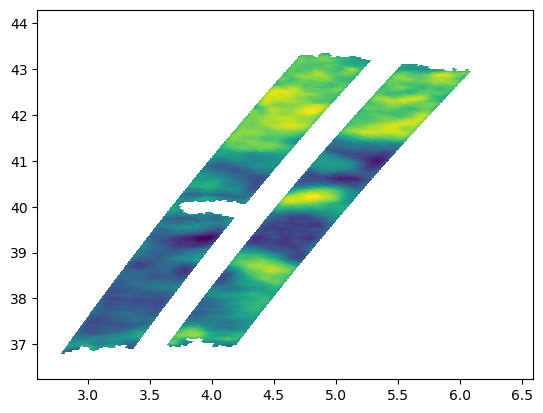

In [22]:
### One filtering save

ds = L3SWOT_rawSSHonly.copy(deep=True)
ds.attrs['DATAPRODUCT'] = 'L3SWOT_filteredSSH_12h2km'

ssh_filtered = L3Field_filtering.ssh_filtering(ds, temporal_sigma=24, spatial_sigma=2)
ds['ssh'] = ds.ssh.copy(data= ssh_filtered)

plt.pcolormesh(ds.longitude, ds.latitude, ds.ssh[12])

ds.to_netcdf(os.path.join(path_save_data, 'field_{}.nc'.format(ds.attrs['DATAPRODUCT'])))

In [23]:
ds

<xarray.Dataset>
Dimensions:    (time: 90, y: 444, x: 69)
Coordinates:
  * time       (time) datetime64[ns] 2023-03-30T00:12:11 ... 2023-07-09T08:16:33
    latitude   (y, x) float32 36.5 36.5 36.5 36.49 ... 44.0 43.99 43.99 43.98
    longitude  (y, x) float32 2.609 2.631 2.653 2.675 ... 6.506 6.53 6.554 6.578
Dimensions without coordinates: y, x
Data variables:
    ssh        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    DATAPRODUCT:   L3SWOT_filteredSSH_24h2km
    gridtype_adt:  T grid : (y, x)

### Compute velocities for a SSH dataset

In [ ]:

DATAPRODUCT = 'L3SWOT_20240626'
dataset_results = None

first_loop = True
for i, file in enumerate(files):
    print('processing file {:02d} over {}'.format(i, len(files)))

    #load domain data
    ds = xr.open_dataset(file, drop_variables=drop_var)
    ds = restrain_domain(ds, *bbox_drifters)

    #get the average time for this file
    mean_time = get_mean_datetime(ds.time.values)
    time_array = np.array([mean_time], dtype='datetime64[ns]')

    #SSH space_time filtering 

    
    #with the local grid num_lines
    lat_mesh, lon_mesh, ssh = jnp.copy(ds.latitude.values), jnp.copy(ds.longitude.values), jnp.copy(ds.ssha.values)
    mask = jnp.isnan(ssh) 

    u_geos, v_geos = jpw.geostrophy(ssh, lat_mesh, lon_mesh, mask=mask, return_grids=False)
    
    lr_scheduler = optax.exponential_decay(1e-2, 200, .5)  # decrease the learning rate
    optim = optax.sgd(learning_rate=lr_scheduler)  # basic SGD works nicely
    optim = optax.chain(optax.clip(1), optim)  # prevent updates from exploding
    
    u_var, v_var, losses_var = jpw.cyclogeostrophy(ssh, lat_mesh, lon_mesh, mask, optim=optim, return_geos=False, return_grids=False, return_losses=True)

    #save data in formatted dataset

    results_one_time = xr.Dataset(

                                data_vars=dict(
                            
                                    ssh    = (["time", "y", "x"], np.expand_dims(ssh, axis=0)),
                                    u_geos = (["time", "y", "x"], np.expand_dims(u_geos, axis=0)),
                                    v_geos = (["time", "y", "x"], np.expand_dims(v_geos, axis=0)),
                                    
                                    u_var  = (["time", "y", "x"], np.expand_dims(u_var, axis=0)),
                                    v_var  = (["time", "y", "x"], np.expand_dims(v_var, axis=0)),
                                ),
                            
                                coords=dict(
                            
                                    time = time_array,
                                    latitude  = (["y", "x"], lat_mesh),
                                    longitude = (["y", "x"], lon_mesh)
                            
                                ),
                            
                                attrs = dict(
                            
                                    DATAPRODUCT=DATAPRODUCT,
                                    gridtype_adt = 'T grid : (latitude, longitude)',
                                    gridtype_uv  = 'U/V grid'
                                    )
                            )
    
    if first_loop:
        dataset_results = results_one_time
        first_loop = False
    else:
        dataset_results = xr.concat([dataset_results, results_one_time], dim="time")



# --- Save results concatenate in time
dataset_results.to_netcdf(os.path.join(path_save_data, 'results_{}.nc'.format(DATAPRODUCT)))